### Hypotheses
- [Lower ripple rate during SD compared NSD](#ripple_rate): One possibility of faster decay of replay during sleep deprivation could be reduced ripple rate at the beginning of POST. This may suggest that in order for cells to replay they need sufficient number/amount of elicitation to last for certain duration of time, so a lower ripple rate could interrupt this requirement.


### Create ripple file backup

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import TimeFrequency
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    +subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    +subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)



In [ ]:
# for sub,sess in enumerate(sessions):
#     sess.ripple.save(sess.filePrefix.with_suffix('.ripples.bak.12-24-2021'))

### Detect ripples for multiple sessions together

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

# sessions = (
#     subjects.sd.ratJday1
#     + subjects.sd.ratKday1
#     +subjects.sd.ratNday1
#     + subjects.sd.ratSday3
#     + subjects.sd.ratRday2
#     + subjects.sd.ratUday4
#     + subjects.sd.ratVday2
#     +subjects.nsd.ratJday2
#     + subjects.nsd.ratKday2
#     + subjects.nsd.ratNday2
#     + subjects.nsd.ratSday2
#     + subjects.nsd.ratRday1
#     + subjects.nsd.ratUday2
#     + subjects.nsd.ratVday1
# )

sessions = subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2


In [ ]:
from tqdm import tqdm
from neuropy.analyses.oscillations import detect_ripple_epochs

for sub, sess in tqdm(enumerate(sessions)):

    try:
        artifact = sess.artifact
    except:
        artifact = None

    channels = sess.ripple.metadata['channels'] 
    signal = sess.eegfile.get_signal(channels)
    ripples = detect_ripple_epochs(
        signal, probegroup=sess.probegroup, freq_band=(125, 250), ignore_epochs=artifact
    )

    # ripples.save(sess.filePrefix.with_suffix('.ripple.npy'))


### Detecting noisy ripples using PCA/KMeans
- Since faster-oscillation artifacts have power in ripple band, these may get picked up during ripple detection based on hilbert transform. These ripple-like artifacts can possibly be eliminated using clustering algorithms.  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = subjects.sd.ratNday1

In [ ]:
from neuropy.utils.signal_process import hilbertfast, filter_sig
from sklearn.decomposition import PCA

for sub, sess in enumerate(sessions):
    good_chans = np.concatenate(sess.probegroup.get_connected_channels())
    pca_ripples = []
    for i in range(len(sess.ripple)):
        rpls = sess.ripple[i].flatten()
        signal = sess.eegfile.get_signal(good_chans.astype("int"), rpls[0], rpls[1])
        hilbert_amp = np.abs(
            hilbertfast(filter_sig.bandpass(signal.traces, lf=130, hf=250, ax=-1), ax=1)
        )

        pca = PCA(n_components=1).fit_transform(hilbert_amp)
        pca_ripples.append(pca.reshape(-1))
pca_ripples = np.asarray(pca_ripples)

In [ ]:
from sklearn.cluster import KMeans,DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from neuropy.core import Epoch
from sklearn.neighbors import LocalOutlierFactor


pca_of_rpl_amp = PCA(n_components=2).fit_transform(pca_ripples)
features = MinMaxScaler().fit_transform(pca_of_rpl_amp) 
labels = GaussianMixture(n_components=2,random_state=0).fit_predict(features)
outliers= LocalOutlierFactor(n_neighbors=20).fit_predict(features)

# starts,stops = sess.ripple.starts,sess.ripple.stops
# weird_ripples = Epoch.from_array(starts[labels==0],stops[labels==0])
# sess.recinfo.write_epochs(weird_ripples,ext='wrp')


In [ ]:
%matplotlib widget

for l in [0,1]:
    plt.plot(features[labels==l,0],features[labels==l,1],'.')

plt.plot(features[outliers==-1,0],features[outliers==-1,1],'k.')

### Ripple power spectrum comaprison 1st vs 5th vs 8th hour
- To see if ripple lfp timeseries changes PSD during sleep deprivation and compare it to NSD
- Method: Ripple traces are concatenated in their corresponding hour and then a PSD is calculated
- Results: Compared to 1st hour, ripple band in 5th and 8th hour show a little shift towards slower frequencies (maybe the start cutoff for ripple band is only changing)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from tqdm import tqdm
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    +subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    +subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

rpl_channels = [39,63,111,95,49,100,85,63,63,36,188,16,99,86]

In [ ]:
import scipy.signal as sg
from neuropy.core import Epoch

psd_rpl_df = pd.DataFrame()
norm_psd = lambda p: p / np.sqrt(p)

for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"]
    maze = sess.paradigm["maze"]
    post = sess.paradigm["post"]
    # rpl_chan = sess.ripple.metadata["channels"][2]
    if sess.tag == "sd":
        post = post.flatten()
        post_epochs = Epoch.from_array(
            [post[0], post[0] + 5 * 3600], [post[0] + 5 * 3600, post[1]], ["sd", "rs"]
        )
        all_epochs = pre + maze + post_epochs
    else:
        all_epochs = pre + maze + post

    psd = []
    for e in all_epochs.itertuples():
        signal = sess.eegfile.get_signal(rpl_channels[sub], e.start, e.stop)
        rpl_t = sess.ripple.time_slice(e.start, e.stop).as_array()
        rpl_frames = [np.arange(int(e[0] * 1250), int(e[1] * 1250)) for e in rpl_t]
        rpl_frames = np.concatenate(rpl_frames) - int(e.start * 1250)
        rpl_frames = rpl_frames[rpl_frames < signal.n_frames]
        f, psd = sg.welch(
            signal.traces[0][rpl_frames], fs=1250, nperseg=125, noverlap=62
        )
        psd_rpl_df = psd_rpl_df.append(
            pd.DataFrame(
                {"freq": f, "psd": psd, "Epoch": e.label, "sub": sub, "grp": sess.tag}
            ),
            ignore_index=True,
        )

subjects.GroupData().save(psd_rpl_df, "ripple_psd")


In [ ]:
# %matplotlib widget
import seaborn as sns
from neuropy.plotting import Fig

figure = Fig()
fig, gs = figure.draw(grid=(5, 4))

for i, grp in enumerate(["sd", "nsd"]):
    df = psd_rpl_df[psd_rpl_df["grp"] == grp]
    ax=plt.subplot(gs[i])
    sns.lineplot(
        data=df,
        x="freq",
        y="psd",
        hue="hour",
        ci=None,
        ax=ax,
        legend=None,
    )
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlim([60,350])
    ax.set_ylim([5,100])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Psd')
    # ax.set_xticks([60,100,200,300],['',100,200,''])
    # ax.set_xticks([100,200],rotation=45)

figure.savefig(subjects.figpath_sd/'ripple_psd_various_epochs')



### Peak ripple frequency distribution from early to late POST
- Since not much was revealed in mean/median wavelet spectrum for first vs third vs fifth hour of SD, I am trying to instead extract peak frequency for each ripple using wavelet and plot their distribution.

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from tqdm import tqdm
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)
rpl_channels = [39,63,111,95,49,100,85,63,63,36,188,16,99,86]
# sessions = subjects.sd.ratUday4
# rpl_channels=[100]


In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat
from neuropy.core import Signal, Epoch
from neuropy.utils.signal_process import filter_sig

peak_f_df = pd.DataFrame()
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"]
    post = sess.paradigm["post"].flatten()

    if np.diff(pre)[0]>3600:
        pre_epoch = Epoch.from_array([pre[1]-3600],[pre[1]],'pre')
    else:
        pre_epoch = Epoch.from_array([pre[0]],[pre[1]],'pre')

    zt = np.array([0, 2, 4, 5, 7])
    t_starts = zt * 3600 + post[0]
    epoch_labels = [f"Zt{i+1}" for i in zt]
    post_epochs = Epoch.from_array(t_starts, t_starts + 3600, epoch_labels)

    all_epochs = pre_epoch + maze + post_epochs
    all_labels = all_epochs.labels

    freqs = np.linspace(100, 250, 150)
    for t, label in zip(all_epochs.as_array(), all_labels):
        signal = sess.eegfile.get_signal(rpl_channels[sub], t[0], t[1]+1)
        rpl_df = sess.ripple.time_slice(t[0], t[1]).to_dataframe()
        peakframe = (rpl_df["peaktime"].values * 1250).astype("int")

        rpl_frames = [np.arange(p - 125, p + 125) for p in peakframe]
        rpl_frames = np.concatenate(rpl_frames) - int(t[0] * 1250)
        rpl_frames = rpl_frames[rpl_frames < signal.n_frames]
        new_sig = Signal(
            signal.traces[0][rpl_frames].reshape(1, -1), sampling_rate=1250
        )
        filt_ = filter_sig.bandpass(new_sig,lf=100,hf=
        250)
        wvlt = WaveletSg(
            signal=filt_,
            freqs=freqs,
            ncycles=10,
        ).traces

        peak_freqs = freqs[
            np.reshape(wvlt/np.sqrt(wvlt), (len(freqs), len(peakframe), -1))
            .max(axis=2)
            .argmax(axis=0)
        ]
        peak_f_df = peak_f_df.append(
            pd.DataFrame({"f": peak_freqs, "t": label,'grp':sess.tag}), ignore_index=True
        )

subjects.GroupData().save(peak_f_df,'ripple_peak_frequency')


In [ ]:
%matplotlib widget
from scipy.ndimage import gaussian_filter1d
from neuropy.utils.signal_process import filter_sig
i=20
wvlt1 =  wvlt.reshape(len(freqs),len(peakframe),-1)[:,i,:]
wv_mean = np.mean(wvlt1,axis=1)
wv_zsc = stats.zscore(wvlt,axis=1)
wv_whiten1= wvlt1/wv_mean[:,np.newaxis]
sig = filt_.traces[0][250*i:250*i+250]
filt = filter_sig.bandpass(sig,lf=120,hf=250,fs=1250)

_,ax = plt.subplots(1,5)
ax[3].plot(sig)
ax[4].plot(filt)
ax[0].imshow(wvlt1,aspect='auto',cmap='jet')
ax[1].imshow(wv_whiten1,aspect='auto',cmap='jet')
ax[2].plot(freqs,wv_mean/np.sqrt(wv_mean))
# ax[2].plot(freqs,np.sum(wv_zsc,axis=1))
# ax[2].plot(freqs,np.sqrt(wv_mean))



In [ ]:
%matplotlib widget

# plt.imshow(wv_whiten,aspect='auto',cmap='jet',vmax=4)
_,ax = plt.subplots(1,3)
wv_whiten_ind = wv_whiten.reshape(len(freqs),len(peakframe),-1)
wv_traces = wvlt.traces.reshape(len(freqs),len(peakframe),-1)
ax[0].plot(freqs,wv_whiten_ind[:,1,:].mean(axis=1))
ax[0].plot(freqs,wv_traces[:,1,:].mean(axis=1)/10)
ax[1].imshow(wv_whiten_ind[:,1,:],aspect='auto')
ax[2].imshow(stats.zscore(wv_traces[:,1,:],axis=1),aspect='auto')

In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy import plotting

# colors = subjects.sd_colors.values()
colors = [subjects.sd.color(1.5),subjects.nsd.color(1.5)]

figure = plotting.Fig() 
fig,gs = figure.draw(grid=(4,2))
# sns.histplot(
#     data=peak_f_df,
#     x="f",
#     hue="t",
#     common_bins=True,
#     common_norm=False,
#     stat="probability",
#     # cumulative=True,
#     binwidth=10,
#     element='poly',
#     fill=False,
# )

ax = plt.subplot(gs[0])
v = sns.violinplot(
    data=peak_f_df,
    x="t",
    y='f',
    hue="grp",
    # estimator=np.median,
    # fill=False,
    # ci='sd',
    palette=colors,
    legend=None,
    marker='o',
    split=True,
    inner='quartile',
    linewidth=1,
    saturation=1,
    # alpha=0.5,
    # color='r',
    # dodge=True,
    # markersize=6,
    # err_style='bars',
    # err_kws={'capsize':3},
    ax=ax,
)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time')
ax.set_title('Peak ripple frequency')
# ax.grid(True)


# figure.savefig(subjects.figpath_sd/'ripple_peak_frequency_POST')

### Peak/Intra ripple frequency maze vs re-maze SD vs NSD

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)
rpl_channels = [95,49,100,85,188,16,99,86]


In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat
from neuropy.core import Signal, Epoch
from neuropy.utils.signal_process import filter_sig

peak_f_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"]
    re_maze = sess.paradigm['re-maze']
    epochs = maze + re_maze

    freqs = np.linspace(100, 250, 150)
    for t, label in zip(epochs.as_array(), epochs.labels):
        signal = sess.eegfile.get_signal(rpl_channels[sub], t[0], t[1]+1)
        rpl_df = sess.ripple.time_slice(t[0], t[1]).to_dataframe()
        peakframe = (rpl_df["peaktime"].values * 1250).astype("int")

        rpl_frames = [np.arange(p - 125, p + 125) for p in peakframe]
        rpl_frames = np.concatenate(rpl_frames) - int(t[0] * 1250)
        rpl_frames = rpl_frames[rpl_frames < signal.n_frames]
        new_sig = Signal(
            signal.traces[0][rpl_frames].reshape(1, -1), sampling_rate=1250
        )
        filt_ = filter_sig.bandpass(new_sig,lf=100,hf=
        250)
        wvlt = WaveletSg(
            signal=filt_,
            freqs=freqs,
            ncycles=10,
        ).traces

        peak_freqs = freqs[
            np.reshape(wvlt/np.sqrt(wvlt), (len(freqs), len(peakframe), -1))
            .max(axis=2)
            .argmax(axis=0)
        ]
        peak_f_df = peak_f_df.append(
            pd.DataFrame({"f": peak_freqs, "t": label,'grp':sess.tag}), ignore_index=True
        )


In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy import plotting

colors = subjects.sd_colors.values()

figure = plotting.Fig() 
fig,gs = figure.draw(grid=(2,2))
# sns.histplot(
#     data=peak_f_df,
#     x="f",
#     hue="t",
#     common_bins=True,
#     common_norm=False,
#     stat="probability",
#     # cumulative=True,
#     binwidth=10,
#     element='poly',
#     fill=False,
# )

ax = plt.subplot(gs[0])
sns.violinplot(
    data=peak_f_df,
    x="t",
    y='f',
    hue="grp",
    # estimator=np.median,
    # fill=False,
    # ci='sd',
    palette=colors,
    marker='o',
    split=True,
    inner='quartile',
    # scale='width',
    # markersize=6,
    # err_style='bars',
    # err_kws={'capsize':3},
    legend=None,
    ax=ax,
)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time')
ax.set_title('Peak ripple frequency')

# figure.savefig(subjects.figpath_sd/'ripple_peak_frequency_maze_vs_re-maze')

### Inter-ripple duration (Ripple ISI)


In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

In [ ]:
dur_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zts =np.array([0,4,5]) # np.arange(0, 9, 4)
    t_starts = zts * 3600 + post[0]

    acg_zt = []
    firing_neurons = []
    for i, t in enumerate(t_starts):
        starts = sess.ripple.time_slice(t, t + 3600).starts
        dur_df = dur_df.append(
            pd.DataFrame(
                {"isi": np.diff(starts), "Zt": f"Zt{zts[i]+1}", "grp": sess.tag}
            ),
            ignore_index=True,
        )


In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy import plotting

figure = plotting.Fig()
fig, gs = figure.draw(grid=(5, 4))
bins = [np.arange(2,50,0.1),np.arange(0.5,50,0.1)]
for i, g in enumerate(["sd", "nsd"]):
    df = dur_df[dur_df['grp']==g]
    ax = plt.subplot(gs[i])
    sns.histplot(
        data=df,
        x="isi",
        hue="Zt",
        ax=ax,
        stat='probability',
        bins= bins[i],
        element='poly',
        common_bins=True,
        common_norm=False,
        fill=False,
        legend=None,
        cumulative=True,
        palette='Set2'
    )
    ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.grid()

figure.savefig(subjects.figpath_sd/'ripple_isi')

### Neurons/MUA acg/ccg during ripples compared early to late of POST for SD and NSD
- I observed change in ripple frequency from early to late sleep. One possibility could be change in synchrony from early to late sleep. For example, in early sleep, neurons are firing in sequences during ripples but later most neurons cofire at same time at a little longer time lag. So here I am plotting acg/ccg or similar measure for change in spiketimes synchrony.
- Didn't find anything interesting in pyramidal neurons but for interneurons if CCGs are sorted by their peak time then Zt2 is more similar to Zt1 compared to Zt5. Probably this is expected

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import subjects
sessions = subjects.nsd.ratNday2+ subjects.nsd.ratSday2+subjects.nsd.ratUday2

In [ ]:
from neuropy.utils.ccg import correlograms

acg_zt1_all = []
acg_zt5_all = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("inter")

    acg_zt = []
    firing_neurons = []
    for t in [post[0],post[0]+4*3600]:
        neurons_t = neurons.time_slice(t, t + 3600)
        n_id = neurons.neuron_ids
        spks = np.concatenate(neurons_t.spiketrains)
        spks_id = np.concatenate(
            [i * np.ones_like(_) for i, _ in zip(n_id, neurons_t.spiketrains)]
        ).astype("int")
        rpl_t = sess.ripple.time_slice(t, t + 3600).flatten()
        spk_bin_ind = np.digitize(spks, rpl_t)
        rpl_indx = spk_bin_ind % 2 == 1
        spks_in_rpl = spks[rpl_indx]
        spks_in_rpl_id = spks_id[rpl_indx]
        sort_ind = np.argsort(spks_in_rpl)
        acg = correlograms(
            spks_in_rpl[sort_ind],
            spks_in_rpl_id[sort_ind],
            sample_rate=30000,
            bin_size=0.001,
            window_size=0.3,
        )
        firing_neurons.append(np.unique(spks_in_rpl_id))
        acg_zt.append(acg)
    _, this, that = np.intersect1d(
        firing_neurons[0], firing_neurons[1], assume_unique=True, return_indices=True
    )

    pairs = np.tril_indices(len(this),k=-1)
    acg_zt = [
        acg_zt[i][np.ix_(ind, ind, np.arange(301))]
        for i, ind in enumerate([this, that])
    ]

    acg_zt = [stats.zscore(_[pairs[0], pairs[1], :],axis=1) for _ in acg_zt]
    nan_indices = np.bitwise_or(*[np.isnan(np.sum(_,axis=1)) for _ in acg_zt])

    acg_zt = [_[~nan_indices,:] for _ in acg_zt]
    acg_zt1_all.append(acg_zt[0])
    acg_zt5_all.append(acg_zt[1])

acg_zt1_all = np.vstack(acg_zt1_all)
acg_zt5_all = np.vstack(acg_zt5_all)

sort_ind = np.argsort(np.argmax(acg_zt1_all,axis=1))

In [ ]:
%matplotlib widget
fig,ax = plt.subplots(1,2)
for i,c in enumerate([acg_zt1_all,acg_zt5_all]):
    ax[i].pcolormesh(c[sort_ind,:])

### Frequency and power distribution comparison between 1st and 5th hour of POST 
- both measures were calculated using wavelet transform
- Runs slow, maybe adding parallel loop for wavelet calculation will help, or move to hilbert amplitude which will be lot faster.
- **Results**: Hardly any changes to ripple power or frequency observed during sleep deprivation or recovery sleep

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)


In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat

rpl_power = pd.DataFrame()
rpl_freq_dist = pd.DataFrame()

for sub, sess in enumerate(sessions):
    print(sess.tag, sub)
    post = sess.paradigm["post"].flatten()
    # sd = sess.paradigm["sd"].flatten()
    sd = [post[0], post[0] + 5 * 3600]
    channels = sess.ripple.metadata["channels"]

    signal = sess.eegfile.get_signal(channels, 1800, 3600)
    hilbert_stat = hilbert_ampltiude_stat(
        signal.traces, freq_band=(150, 250), fs=1250, statistic="median"
    )

    channel = channels[np.argmax(hilbert_stat)]

    freqs = np.arange(130, 250, 2)
    rpls_1h = sess.ripple.time_slice(sd[0], sd[0] + 3600).set_labels("1st")
    rpls_5h = sess.ripple.time_slice(sd[0] + 4 * 3600, sd[1]).set_labels("5th")
    rpls_6h = sess.ripple.time_slice(sd[1], sd[1] + 3600).set_labels("6th")

    rpls_comb = rpls_1h + rpls_5h + rpls_6h
    max_power, freq_dist = [], []
    for start, stop in zip(rpls_comb.starts, rpls_comb.stops):
        signal = sess.eegfile.get_signal(channel, start, stop)
        wvlt = WaveletSg(signal=signal, freqs=freqs, ncycles=10)
        wvlt_mean = wvlt.mean_power()
        max_power.append(np.max(wvlt_mean))
        freq_dist.append(np.mean(wvlt.traces, axis=1))

    df1 = pd.DataFrame(
        {
            "max_power": np.array(max_power),
            "hour": rpls_comb.labels,
            "sub": sub,
            "grp": sess.tag,
        }
    )
    df2 = pd.DataFrame(np.asarray(freq_dist), columns=freqs)
    df2["hour"] = rpls_comb.labels
    df2["sub"] = sub
    df2["grp"] = sess.tag
    df2 = pd.melt(
        df2,
        id_vars=["hour", "sub", "grp"],
        value_vars=freqs,
        var_name=["freq"],
        value_name="freq_power",
        ignore_index=True,
    )

    rpl_power = rpl_power.append(df1).reset_index(drop=True)
    rpl_freq_dist = rpl_freq_dist.append(df2).reset_index(drop=True)


#### Frequency distribution plot

In [ ]:
%matplotlib widget
import seaborn as sns

dist = sns.relplot(
    data=rpl_freq_dist,
    x="freq",
    y='freq_power',
    hue="hour",
    ci=None,
    kind='line',
    row="sub",
    col='grp',
    height=1.5,
    aspect=2,
    lw=1,
)

# dist.figure.savefig(subjects.figpath_sd/'ripple_power_dist_Zt1_vs_Zt5.pdf')

#### Power distribution plot

In [ ]:
%matplotlib widget
from neuropy import plotting
import seaborn as sns

dist = sns.displot(
    data=rpl_power,
    x="max_power",
    hue="hour",
    stat="probability",
    # binrange=(0, 140),
    kind='hist',
    row="sub",
    col='grp',
    cumulative=False,
    # ax=ax,
    element="step",
    fill=False,
    common_norm=False,
    height=1.5,
    aspect=2,
    lw=1,
    # alpha=0.8,
    palette=['#5cc0eb','#faa49d','#05d69e'],
    
)

# dist.figure.savefig(subjects.figpath_sd/'ripple_power_dist_Zt1_vs_Zt5_vs_Zt6.pdf')


### Peri SWR spectrogram at selected ZTs for POST
- Basically average wavelet spectrogram across all ripples
- For SD sessions, I did not find any interesting dynamics other than an additional bump in the 15-30 Hz for Zt1, Zt3 and Zt5. Probably similar to what has been reported in Oliva2018 (Origin of gamma frequency power during hippocampal swrs).
- Did not do this analysis for NSD sessions.

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    # + subjects.nsd.ratKday2
    # subjects.nsd.ratNday2
    # + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    # + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)
rpl_channels = [39,63,111,95,49,100,85,63,63,36,188,16,99,86]
# rpl_channels=[100]


In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat
from neuropy.core import Signal

spect = []
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    # rpl_chan = sess.ripple.metadata["channels"][2]

    t_starts = np.arange(0, 5, 2) * 3600 + post[0]

    freqs = np.geomspace(4, 350, 200)
    for t in t_starts:
        signal = sess.eegfile.get_signal(rpl_channels[sub], t, t + 3601)
        rpl_df = sess.ripple.time_slice(t, t + 3600).to_dataframe()
        peakframe = (rpl_df["peaktime"].values * 1250).astype("int")

        rpl_frames = [np.arange(p - 250, p + 250) for p in peakframe]
        rpl_frames = np.concatenate(rpl_frames) - int(t * 1250)
        rpl_frames = rpl_frames[rpl_frames < signal.n_frames]
        new_sig = Signal(
            signal.traces[0][rpl_frames].reshape(1, -1), sampling_rate=1250
        )
        wvlt = WaveletSg(
            signal=new_sig,
            freqs=freqs,
            ncycles=10,
        )
        # wvlt_mean = np.reshape(wvlt.traces, (len(freqs), len(peakframe), -1)).mean(
        #     axis=1
        # )
        wvlt_median = np.median(
            np.reshape(wvlt.traces, (len(freqs), len(peakframe), -1)), axis=1
        )
        spect.append(wvlt_median)


In [ ]:
%matplotlib widget
from neuropy.plotting import Fig
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm

figure = Fig()
fig, gs = figure.draw(grid=(5, 3))

for i in range(3):
    s = np.dstack(spect[i::3]).mean(axis=-1)
    # s = gaussian_filter(s,sigma=2)
    ax = plt.subplot(gs[i])
    ax.imshow(
        # np.linspace(-200, 200, 500),
        # freqs,
        stats.zscore(s, axis=1),
        # s,
        # extent=[-200,200],
        cmap="jet",
        # shading="gouraud",
        # vmax= 5,
        # norm=LogNorm(),
        interpolation='sinc',
        origin='lower',
        aspect='auto',
    )
    # ax.set_yscale('log')
    ax.set_yticks(np.arange(200)[::30],freqs[::30].round().astype('int'))
    ax.set_xticks([125,250,375],[-100,0,100])
    # ax.plot(np.median(s,axis=1))
# plt.yscale('log')

figure.savefig(subjects.figpath_sd/'ripple_peri_spectrogram_SD')

### Spike triggered raster plot w.r.t ripples during sleep deprivation for individual neurons

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import subjects

sessions = subjects.sd.ratSday3

In [ ]:
for sub,sess in enumerate(sessions):
    sd = sess.paradigm['sd']
    rpls = sess.ripple.time_slice(sd[0],sd[1])
    

### Total/mean ripple duration from first hour to last hour SD

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)


In [ ]:
rpl_duration = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = np.arange(9) * 3600 + post[0]

    for i, t in enumerate(period):

        rpl_duration = rpl_duration.append(
            pd.DataFrame(
                {
                    "Zt": f"{i+1}",
                    "rpl_duration": [sess.ripple.time_slice(t, t + 3600).durations.sum()],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
            ignore_index=True,
        )


subjects.GroupData().save(rpl_duration, "ripple_total_duration")


In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy import plotting

# plt.figure(figsize=(8,11))
figure = plotting.Fig()
fig, gs = figure.draw(grid=(5, 4))

for i, grp in enumerate(["sd", "nsd"]):
    data = rpl_duration[rpl_duration["grp"] == grp]
    ax = plt.subplot(gs[i])
    sns.lineplot(
        data=data,
        x="epoch",
        y="rpl_duration",
        hue="sub",
        marker="o",
        palette=["gray"] * 7,
        ax=ax,
        legend=None,
    )
    ax.set_xlim([-1,4])
    ax.set_ylim([30,450])


# g=sns.relplot(
#     data=rpl_duration,
#     x="epoch",
#     y="rpl_duration",
#     hue="sub",
#     col="grp",
#     # row='rpl_duration',
#     kind="line",
#     marker="o",
#     palette=['gray']*len(sessions),
# )

# [ax.set_xlim([-1,2]) for ax in g.axes.reshape(-1)]
# figure.savefig(subjects.figpath_sd/'ripple_total_duration_zt1_vs_zt5')

### Interneuron categorization based on firing rate around ripples start
- using CCG algorithm

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
from neuropy.utils.ccg import correlograms
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    # + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    # + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)


In [ ]:
acgs = []
bin_size = 0.01
window_size = 0.2
n_bins = int(window_size // bin_size)
for sub, sess in enumerate(sessions):
    ripple = sess.ripple.to_dataframe().peaktime.values
    neurons = sess.neurons.get_neuron_type("inter")
    for s in neurons.spiketrains:
        combined_s = np.concatenate((s, ripple))
        combined_id = np.concatenate(
            (np.ones(len(s)), 2 * np.ones(len(ripple)))
        ).astype("int")
        sort_ind = np.argsort(combined_s)
        acg = correlograms(
            combined_s[sort_ind],
            combined_id[sort_ind],
            sample_rate=30000,
            bin_size=bin_size,
            window_size=window_size,
        )
        acgs.append(acg[0, 1, :])

acgs = np.asarray(acgs)
t_bin = np.linspace(-n_bins // 2, n_bins // 2, acgs.shape[1])
data = pd.DataFrame(stats.zscore(acgs, axis=1), columns=t_bin)
data["neuron"] = np.arange(acgs.shape[0])
data = pd.melt(
    data,
    id_vars=["neuron"],
    value_vars=t_bin,
    var_name=["time"],
    value_name="frate",
    ignore_index=True,
)

In [ ]:
%matplotlib widget
import seaborn as sns

_,axs = plt.subplots(10,9,sharex=True,sharey=True)
axs = axs.reshape(-1)

acgs_norm = acgs/np.sum(acgs,axis=1,keepdims=True)

for i,a in enumerate(acgs_norm):

    axs[i].fill_between(t_bin,0,a)


# from neuropy.core import Ratemap

# rmap = Ratemap(acgs,np.arange(52),neuron_ids=np.arange(acgs.shape[0]))
# plotting.plot_ratemap(rmap,normalize_tuning_curve=True,pad=2)

# sns.catplot(data=data,x='time',y='frate',col='neuron',col_wrap=5,kind='bar')
# sns.relplot(data=data,x='time',y='frate',col='neuron',col_wrap=5,kind='line')

### Interneurons categorization based on ripple modulation
- The method here is similar to Diba et.al. 2014.
- Here the code that worked and shows some kmeans clustering to identify different categories.
- NOTE: The main has now been ported to ripple_funcs.py in the current directory

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
from neuropy.utils.ccg import correlograms
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    # + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)


In [ ]:
from sklearn.cluster import KMeans
from ripple_funcs import ripple_modulation

frate_around_rpl = []
for sub, sess in enumerate(sessions):
    neurons = sess.neurons.get_neuron_type("inter")
    n_neurons = len(neurons)
    ripples = sess.ripple.to_dataframe()

    start, peak, stop = sess.ripple.to_dataframe()[
        ["start", "peaktime", "stop"]
    ].values.T
    modulation = ripple_modulation(neurons, start, peak, stop, n_bins=4)
    frate_around_rpl.append(modulation)

frate_around_rpl = np.vstack(frate_around_rpl)
frate_norm = frate_around_rpl / np.sum(frate_around_rpl, axis=1, keepdims=True)
kmeans = KMeans(n_clusters=2, random_state=0).fit(frate_norm)


#### PCA projection of interneurons modulation

In [ ]:
%matplotlib inline
from sklearn.decomposition import PCA
from neuropy import plotting

pca = PCA(n_components=2)
pca.fit(frate_norm)
projected = pca.fit_transform(frate_norm)

# figure = plotting.Fig()
# fig,gs = figure.draw(grid=(1,2))
# gs_ = figure.subplot2grid(gs[1],grid=(2,1))
fig = plt.figure(figsize=(12, 5))
subfigs = fig.subfigures(1, 2, wspace=0.7)
ax_pca = subfigs[0].subplots(1, 1)
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")

hist_figs = subfigs[1].subfigures(2, 1)

colors = ["r", "k"]
for label in [0, 1]:
    indices = kmeans.labels_ == label
    ax_pca.scatter(projected[indices, 0], projected[indices, 1], c=colors[label])

    ind_subset = np.random.choice(np.where(indices)[0], 8)
    frate_subset = frate_norm[ind_subset]
    ax_hists = hist_figs[label].subplots(2, 4, sharex=True, sharey=True).reshape(-1)
    for i, f in enumerate(frate_subset):
        ax_hists[i].stairs(f, np.arange(-8, 9), color=colors[label], fill=True)
        ax_hists[i].set_xticks([-5, 0, 5])
        ax_hists[i].set_xticklabels([-1, 0, 1])

# fig.savefig(subjects.figpath_sd/'interneuron_ripple_classification.pdf')


### Ripple duration comparison between SD and NSD animals
- First, I compared the ripple duration distribution for Zt1 between NSD and SD sessions. Ripple durations were pooled across sessions. The distribution curves looked exactly the same for both groups.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    +subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2

    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

In [ ]:
rpl_dur = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    t_starts = np.arange(5) * 3600 + post[0]
    # t = post[0]

    # --- for zt1 comparison ------
    # rpl_dur = rpl_dur.append(
    #     pd.DataFrame(
    #         {
    #             "durations": sess.ripple.time_slice(t, t +1* 3600).durations,
    #             "grp": sess.tag,
    #         }
    #     ),
    #     ignore_index=True,
    # )

    # --- for hourly comparison between SD and NSD -----
    rpl_dur = rpl_dur.append(
        pd.concat(
            [
                pd.DataFrame(
                    {
                        "durations": sess.ripple.time_slice(t, t + 3600).durations,
                        "zt": ind + 1,
                        "grp": sess.tag,
                    }
                )
                for ind, t in enumerate(t_starts)
            ]
        ),
        ignore_index=True,
    )


In [ ]:
# %matplotlib widget
import seaborn as sns
from neuropy.plotting import Fig

figure = Fig()
fig, gs = figure.draw(grid=(5, 4))

for i, grp in enumerate(["sd", "nsd"]):
    df = rpl_dur[rpl_dur["grp"] == grp]
    ax = plt.subplot(gs[i])
    ax = sns.histplot(
        data=df,
        x="durations",
        hue="zt",
        stat="probability",
        bins=np.arange(0.05, 0.455, 0.010),
        common_norm=False,
        # cumulative=True,
        element="poly",
        fill=False,
        ax=ax,
        # legend=None,
        palette="Set2",
    )
    ax.set_xscale('log')
    ax.set_xticks([0.1,0.4])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_yscale('log')
    # ax.ticklabel_format(axis='x',style='sci')

# figure.savefig(subjects.figpath_sd/'ripple_duration_distribution')

### Ripple rate first 5 hour **within** SD and NSD across Zt times


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    +subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2

    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

# sessions = subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2

In [ ]:
ripple_rate_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 9* 3600]
    rpls = sess.ripple.starts

    binsz = 3600
    n_bins = np.diff(period)/ binsz
    sd_bin = np.arange(n_bins + 1) * binsz + period[0]
    hist_rpl = np.histogram(rpls, bins=sd_bin)[0]
    # hist_rpl = hist_rpl / np.sum(hist_rpl)

    ripple_rate_df = ripple_rate_df.append(
        pd.DataFrame(
            {
                "rate": hist_rpl / binsz,
                "Zt": (sd_bin[:-1] - sd_bin[0]) / 3600 +1,
                "sub": sub,
                "grp": sess.tag,
            }
        ),
        ignore_index=True,
    )

subjects.GroupData().save(ripple_rate_df,'ripple_rate')

In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy.plotting import Fig

figure = Fig()
fig, gs = figure.draw(grid=(5, 4))

for i, grp in enumerate(["sd",'nsd']):
    df = ripple_rate_df[ripple_rate_df["grp"] == grp]
    ax = plt.subplot(gs[i])
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        ax=ax,
        hue="sub",
        legend=False,
        palette=["#BDBDBD"] * 7,
        # ls="--",
    )
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        estimator=np.median,
        ax=ax,
        legend=False,
        color='k',
        ls="--",
        ci=None,
        lw=2,
    )
    # ax.set_yscale('log')
    ax.set_ylim([0.08, 0.65])
    ax.set_xticks(np.arange(1, 10, 2))

# figure.savefig(subjects.figpath_sd/'ripple_rate')

### Ripple rate first hour **between** SD and NSD (or only restrict to 1h NREM sleep of NSD)
- One possiblity of faster decay of replay during sleep deprivation could be reduced ripple rate at the begining of POST. This may suggest that in order for cells to replay they need sufficient number/amount of exicitation to last for certain duration of time, so a lower ripple rate could interrupt this requirement.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    +subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2

    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

In [ ]:
rpl_rate = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    w = 2 * 3600 # window size
    rpl_rate_sub = sess.ripple.time_slice(post[0], post[0] + w).n_epochs / w
    rpl_rate = rpl_rate.append(
        pd.DataFrame({"sub": sess.sub_name, "rpl_rate": [rpl_rate_sub], "grp": sess.tag})
    ).reset_index(drop=True)


In [ ]:
%matplotlib widget
import seaborn as sns

sns.lineplot(data=rpl_rate,x='grp',y='rpl_rate',hue='sub',marker='o')

### Percentage of Cells firing during ripples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4

    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)

In [ ]:
for sub,sess in enumerate(sessions):
    post = sess.paradigm['post'].flatten()
    neurons = sess.neurons.get_neuron_type('pyr')
    rpls = sess.ripple.time_slice(post[0],post[0]+3600)
    modulation = neurons.get_modulation_in_epochs(rpls,n_bins=1).reshape(-1)
    firing_cells = np.where(modulation>0)[0]
    perc = len(firing_cells)/len(modulation)
    print(perc)

### Firing rate within and outside ripples during SD and NSD

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.sd.ratRday2

    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

In [102]:
from neuropy.core import Epoch

frate_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    pre = sess.paradigm["pre"]
    maze = sess.paradigm["maze"]
    post = sess.paradigm["post"].flatten()
    spktrns = sess.neurons.get_neuron_type("inter").spiketrains

    post_starts = np.arange(9) * 3600 + post[0]
    post_labels = [f"Zt{_+1}" for _ in range(len(post_starts))]

    # NOTE: subtracted 0.1 to keep the bins monotonically increasing
    post_epochs = Epoch.from_array(post_starts, post_starts + 3600 - 0.1, post_labels)

    all_epochs = pre + maze + post_epochs

    rpls = sess.ripple.time_slice(pre.flatten()[0], post[0] + 9 * 3600)
    n_spikes = np.asarray(
        [np.histogram(spk, bins=rpls.flatten())[0] for spk in spktrns]
    )
    in_rpl = n_spikes[:, ::2]
    # out_rpl = n_spikes[:, 1::2]

    zt_spikes_in = stats.binned_statistic(
        rpls.starts, in_rpl, bins=all_epochs.flatten(), statistic="sum"
    )[0][:, ::2]

    n_rpls = np.histogram(rpls.starts, bins=all_epochs.flatten())[0][::2][np.newaxis, :]

    zt_spikes_in = zt_spikes_in / n_rpls

    # the bin size may not be appropriate for out rpls
    # zt_spikes_out= stats.binned_statistic(
    #     rpls.starts, in_rpl, bins=all_epochs.flatten(), statistic="sum"
    # )[0]

    in_rpl = stats.zscore(zt_spikes_in, axis=1)
    assert in_rpl.shape[0] == len(spktrns), "booo"

    frate_sub_df = pd.DataFrame(in_rpl, columns=all_epochs.labels)
    # frate_sub_df["rpl"] = ["in"] * len(spktrns) + ["out"] * len(spktrns)
    frate_sub_df["grp"] = sess.tag

    frate_df = frate_df.append(frate_sub_df).reset_index(drop=True)

frate_df = pd.melt(
    frate_df,
    id_vars=["grp"],
    value_vars=all_epochs.labels,
    var_name="time",
    value_name="frate",
    ignore_index=True,
)

subjects.GroupData().save(frate_df,'frate_inter_in_ripple')
# subjects.GroupData().save(frate_df, "frate_pyr_in_ripple")


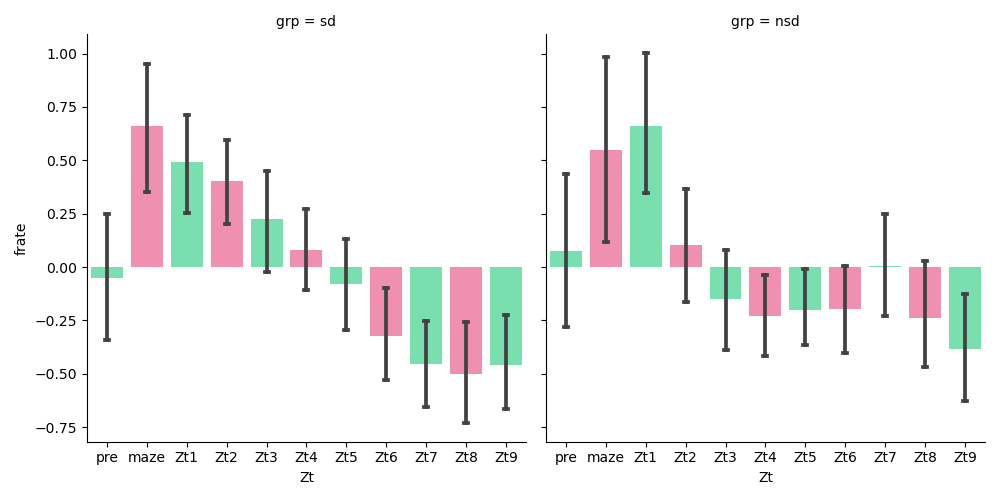

In [99]:
%matplotlib widget
import seaborn as sns

g = sns.catplot(
    data=frate_df,
    x="Zt",
    y="frate",
    # hue="rpl",
    col="grp",
    kind="bar",
    palette=["#69F0AE", "#FF80AB"],
    ci=95,
    capsize=0.1,
)
axes = g.axes[0]
# [ax.set_yscale('log') for ax in axes]


### Firing rate (scatter plot) within and outside ripples during SD and NSD

In [18]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.sd.ratRday2

    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

In [ ]:
from neuropy.core import Epoch
from neuropy.utils.mathutil import min_max_scaler

in_rpl,out_rpl,time =[],[],[]
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("pyr")
    spktrns = neurons.spiketrains
    starts = np.arange(9) * 3600 + post[0]

    rpls = sess.ripple.time_slice(post[0],post[0]+9*3600).flatten()

    n_spikes = np.asarray([np.histogram(spk,bins=rpls)[0] for spk in spktrns])
    in_rpl.append(n_spikes[:,::2])
    out_rpl.append(n_spikes[:,1::2])
    time.append(rpls[::2]-post[0])


# frate_df = pd.melt(
#     frate_df,
#     id_vars=["rpl", "grp"],
#     value_vars=np.arange(1,9),
#     var_name="Zt time",
#     value_name="frate",
#     ignore_index=True,
# )


In [ ]:
%matplotlib widget
import seaborn as sns

data = stats.zscore(in_rpl[0],axis=1)
for i in range(97):
    plt.plot(time[0],data[i],'k.')

### PSTH around start of ripples during sleep deprivation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4

    +subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)

In [ ]:
from neuropy.core import Epoch

frate_around_rpl,grp_info = [],[]
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("pyr")
    grp_info.extend([sess.tag] * len(neurons))

    get_modulation = lambda e: neurons.get_modulation_in_epochs(e, 2)

    hour_modulation = []
    for t in [post[0], post[0] + 4 * 3600]:
        ripples = sess.ripple.time_slice(t, t + 3600)
        start, peak = ripples.to_dataframe()[["start", "peaktime"]].values.T
        start_peak_dur = peak - start
        epochs = Epoch.from_array(start - start_peak_dur, start + start_peak_dur)

        modulation = []
        for s in range(3):
            epoch_slices = epochs[s::3]  # [_[s::3] for _ in (pre_start, start_peak)]
            modulation.append(get_modulation(epoch_slices))
        hour_modulation.append(np.dstack(modulation).sum(axis=2)/ripples.durations.sum())

    frate_around_rpl.append(np.hstack(hour_modulation))

frate_around_rpl = np.vstack(frate_around_rpl)
# frate_norm = frate_around_rpl / np.sum(frate_around_rpl, axis=1, keepdims=True)
frate_norm = stats.zscore(frate_around_rpl, axis=1)

# bins = np.arange(-8, 9)
frate_rpl_df = pd.DataFrame(
    frate_around_rpl, columns=["pre_1h", "post_1h", "pre_5h", "post_5h"]
)
frate_rpl_df["grp"] = grp_info

# frate_session_df = pd.melt(
#     frate_session_df,
#     id_vars=["grp", "label"],
#     value_vars=time_bin,
#     var_name=["time"],
#     value_name="frate",
#     ignore_index=True,
# )


In [ ]:
%matplotlib widget
import seaborn as sns

figure = plotting.Fig()
fig,gs = figure.draw(grid=(2,2))

for i,grp in enumerate(['sd','nsd']):
    df = frate_rpl_df[frate_rpl_df['grp']==grp]

    ax_pre = plt.subplot(gs[i,0])
    sns.scatterplot(data=df ,x='pre_1h',y='pre_5h',ax=ax_pre)
    ax_pre.set_xscale('log')
    ax_pre.set_yscale('log')
    ax_pre.axline((0,0),(1,1))


    ax_post = plt.subplot(gs[i,1])
    sns.scatterplot(data=df ,x='post_1h',y='post_5h',ax=ax_post)
    ax_post.set_xscale('log')
    ax_post.set_yscale('log')
    ax_post.axline((0,0),(1,1))
